# Part1: Fundamental Estimation

In [104]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [120]:
##
## load images and match files for the first example
##

I1 = Image.open('lab1.jpg');
I2 = Image.open('lab2.jpg');
matches = np.loadtxt('lab_matches.txt'); 

print(matches)

[[ 880.  214.  731.  238.]
 [  43.  203.   22.  248.]
 [ 270.  197.  204.  230.]
 [ 886.  347.  903.  342.]
 [ 745.  302.  635.  316.]
 [ 943.  128.  867.  177.]
 [ 476.  590.  958.  572.]
 [ 419.  214.  328.  244.]
 [ 317.  335.  426.  386.]
 [ 783.  521. 1064.  470.]
 [ 235.  427.  480.  495.]
 [ 665.  429.  964.  419.]
 [ 655.  362.  695.  374.]
 [ 427.  333.  505.  372.]
 [ 412.  415.  645.  452.]
 [ 746.  351.  692.  359.]
 [ 434.  415.  712.  444.]
 [ 525.  234.  465.  263.]
 [ 716.  308.  591.  324.]
 [ 602.  187.  447.  213.]]


In [106]:
# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

In [107]:
def normalize(points):
    """
    Normalize coordinates of matching points.
    """
    # Compute centroid of points
    centroid = np.mean(points, axis=0)

    # Translate points so that centroid is at origin
    translated_points = points - centroid

    # Compute average distance from origin
    avg_distance = np.mean(np.sqrt(np.sum(translated_points**2, axis=1)))

    # Scale points so that average distance from origin is sqrt(2)
    scale = np.sqrt(2) / avg_distance

    # Construct normalization matrix
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])

    return T

In [108]:
def unnormalized_fit_fundamental(matches):
    """
    Fit a fundamental matrix to the given matching points using unnormalized method.
    """
    # Extract coordinates of matching points
    pts1 = matches[:, :2]
    pts2 = matches[:, 2:]

    # Construct the A matrix for linear equation
    A = np.zeros((len(pts1), 9))
    for i in range(len(pts1)):
        A[i] = [
            pts1[i][0] * pts2[i][0],
            pts1[i][0] * pts2[i][1],
            pts1[i][0],
            pts1[i][1] * pts2[i][0],
            pts1[i][1] * pts2[i][1],
            pts1[i][1],
            pts2[i][0],
            pts2[i][1],
            1
        ]

    # Solve for the fundamental matrix using SVD
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    return F

In [109]:
def fit_fundamental(matches):
    """
    Fit a fundamental matrix to the given matching points using normalized method.
    """
    # Extract coordinates of matching points
    pts1 = matches[:, :2]
    pts2 = matches[:, 2:]

    # Normalize the coordinates
    T1 = normalize(pts1)
    T2 = normalize(pts2)
    pts1_norm = np.dot(T1, np.vstack((pts1.T, np.ones(len(pts1))))).T
    pts2_norm = np.dot(T2, np.vstack((pts2.T, np.ones(len(pts2))))).T

    # Construct the A matrix for linear equation
    A = np.zeros((len(pts1), 9))
    for i in range(len(pts1)):
        A[i] = [
            pts1_norm[i][0] * pts2_norm[i][0],
            pts1_norm[i][0] * pts2_norm[i][1],
            pts1_norm[i][0],
            pts1_norm[i][1] * pts2_norm[i][0],
            pts1_norm[i][1] * pts2_norm[i][1],
            pts1_norm[i][1],
            pts2_norm[i][0],
            pts2_norm[i][1],
            1
        ]

    # Solve for the fundamental matrix using SVD
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    # Denormalize the fundamental matrix
    F = np.dot(T2.T, np.dot(F, T1))

    return F

In [114]:
##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = unnormalized_fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

In [115]:
# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

In [116]:
# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


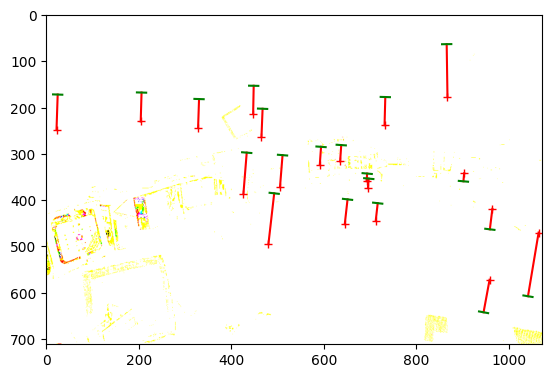

In [117]:
# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(float))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

In [118]:
def evaluate_residual(F, matches):
    """
    Compute the residual, i.e., the mean squared distance in pixels
    between points in both images and the corresponding epipolar lines.
    """
    N = len(matches)
    # Extract coordinates of matching points
    pts1 = matches[:, :2]
    pts2 = matches[:, 2:]

    # Compute epipolar lines in the second image
    lines = np.dot(F, np.hstack((pts1, np.ones((N, 1)))).T)
    # Normalize line equations
    norms = np.sqrt(lines[0]**2 + lines[1]**2)
    lines /= norms

    # Compute distances from points in the second image to their corresponding epipolar lines
    distances = np.abs(np.sum(lines * np.hstack((pts2, np.ones((N, 1)))).T, axis=0))

    # Compute mean squared distance (residual)
    residual = np.mean(distances**2)

    return residual

In [119]:
# Fit fundamental matrix using normalized method
F_normalized = fit_fundamental(matches)
# Compute residual for normalized method
residual_normalized = evaluate_residual(F_normalized, matches)

# Fit fundamental matrix using unnormalized method
F_unnormalized = unnormalized_fit_fundamental(matches)
# Compute residual for unnormalized method
residual_unnormalized = evaluate_residual(F_unnormalized, matches)

print("Normalized Method Residual:", residual_normalized)
print("Unnormalized Method Residual:", residual_unnormalized)

Normalized Method Residual: 3125.5062959537036
Unnormalized Method Residual: 4866.075470062337


# Part 2: Camera Calibration

In [122]:
import numpy as np

# Load 2D matches from the lab pair
matches = np.loadtxt('lab_matches.txt')
pts1 = matches[:, :2]
pts2 = matches[:, 2:]

# Load 3D point coordinates
points_3d = np.loadtxt('lab_3d.txt')

def calculate_projection_matrix(pts1, pts2, points_3d):
    """
    Calculate the camera projection matrices.
    """
    # Construct the A matrix
    A = np.zeros((len(pts1) * 2, 12))
    for i in range(len(pts1)):
        A[2*i, :4] = np.hstack((points_3d[i], 1))
        A[2*i, 8:] = -pts1[i][0] * np.hstack((points_3d[i], 1))
        A[2*i + 1, 4:8] = np.hstack((points_3d[i], 1))
        A[2*i + 1, 8:] = -pts1[i][1] * np.hstack((points_3d[i], 1))

    # Solve for the projection matrix using SVD
    _, _, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 4)

    return M

# Calculate the camera projection matrices
M1 = calculate_projection_matrix(pts1, pts2, points_3d)
M2 = calculate_projection_matrix(pts2, pts1, points_3d)

def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return: points_3d_proj, residual
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u - points_2d[:, 0], v - points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Evaluate the projection matrices
proj_points1, residual1 = evaluate_points(M1, pts1, points_3d)
proj_points2, residual2 = evaluate_points(M2, pts2, points_3d)

print("Projection Matrix 1 Residual:", residual1)
print("Projection Matrix 2 Residual:", residual2)


Projection Matrix 1 Residual: 13.54583289329173
Projection Matrix 2 Residual: 15.544953452595896
